In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse

from astropy import units as u
from astropy.time import Time
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook as tqdm

import glob, os
from scripts import load_lightcurve

from astropy.table import Table, join, Column, unique
plt.rcParams['font.size'] = 20
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['savefig.dpi']= 300             #72 
# mpl.rcParams["font.family"] = "Computer Modern Roman"
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [47]:
data = Table.read('joined_lofar.csv',format='ascii')
print(data.keys())

['Name', 'LOFAR Lum (x1E14 ergs/s/Hz)', 'Soft X-ray Lum (x1E28 ergs/s)', 'Uncert. Lofar Lum', 'Literature Rotation Period', 'Rotation Period', 'Flare Rate', 'N Flares', 'N Sectors', 'TIC']


In [3]:
lit, measured = data['Literature Rotation Period'],data['Rotation Period']

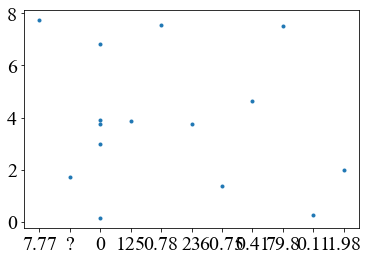

In [4]:
plt.plot(lit,measured,'.')

In [5]:
xray= np.array(data['Soft X-ray Lum (x1E28 ergs/s)'])
radio = np.array(data['LOFAR Lum (x1E14 ergs/s/Hz)'])
dradio = np.array(data['Uncert. Lofar Lum'])
flarerate = np.array(data['Flare Rate'])
names = np.array(data['Name'])

quiescent = ['GJ 625', 'GJ 450', 'GJ 1151', 'LP 169-22', 'G 240-45']
binaries = ['DG CVn', 'CR Dra', 'GJ 3861']

In [6]:
uplims = ['<' in xr for xr in xray]
xrayclean = [float((xr).strip('<')) for xr in xray]

<ipython-input-7-adc82b944ece>:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  thismap.set_bad(color='k')
<ipython-input-7-adc82b944ece>:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  sc.cmap.set_under('k')


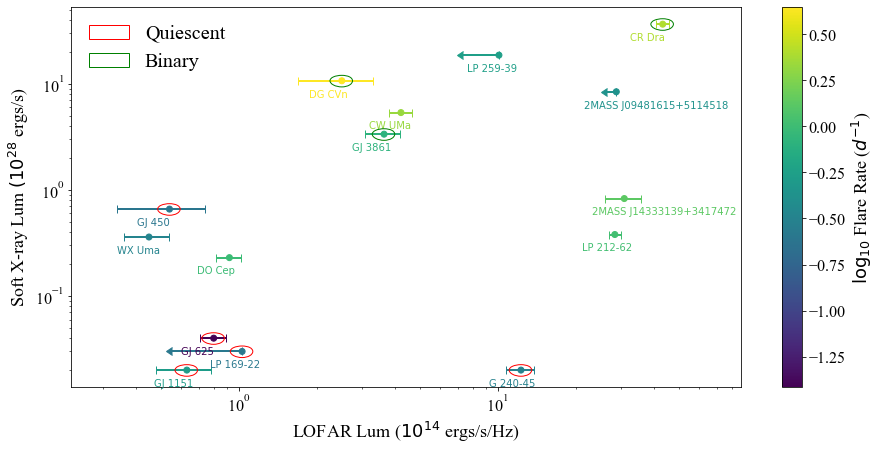

In [7]:
fig = plt.figure(figsize=(15.0,7.0))
ax = plt.gca()

this_mappable = np.log10((flarerate))
bad = ~np.isfinite(this_mappable)
this_mappable[bad] = np.nan

vmin,vmax = np.nanmin(this_mappable),np.nanmax(this_mappable)
this_mappable[bad] = -10

thismap = mpl.cm.viridis
thismap.set_bad(color='k')

sc = plt.scatter(radio,xrayclean,c=this_mappable,cmap=thismap)
sc.cmap.set_under('k')
sc.set_clim(vmin, vmax)

#create colorbar according to the scatter plot
clb = plt.colorbar(sc)
clb.set_label(r'$\log_{10}$ Flare Rate ($d^{-1}$)',fontsize=18)
clb.ax.tick_params(labelsize=16) 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=thismap)
this_mappable[bad] = np.nan
color = np.array([(mapper.to_rgba(v)) for v in this_mappable])

for j in range(15):
    plt.errorbar(radio[j],xrayclean[j],xerr=dradio[j],xuplims=uplims[j],ls='None',c=color[j], lw=2, capsize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(radio)*0.5,np.max(radio)*2)
plt.xlabel('LOFAR Lum ($10^{14}$ ergs/s/Hz)',fontsize=18)
plt.ylabel(r'Soft X-ray Lum $(10^{28}$ ergs/s)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


for j, star in enumerate(names):
    wh = np.where(names==star)[0][0]
    plt.text(radio[wh]*0.75,xrayclean[wh]*0.7,star,fontsize=10,c=color[j],fontname='DejaVu Sans')
# fig.colorbar(mpl.cm.ScalarMappable(norm=None,cmap=mpl.cm.hot(flarerate)))

for j, star in enumerate(quiescent):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    f = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='r',zorder=11,
               transform=ax.transData)
    fig.add_artist(f)

    
for j, star in enumerate(binaries):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    g = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='g',zorder=11,
               transform=ax.transData)
    fig.add_artist(g)

plt.legend([f,g],['Quiescent','Binary'],frameon=False)
plt.savefig('gudel_benz_flares.png',bbox_inches='tight')
plt.savefig('gudel_benz_flares.pdf',bbox_inches='tight')

In [8]:
gudel_m_dwarfs = Table.read('../data/m_dwarfs_gudel2002.csv',format='ascii')
gudel_k_dwarfs = Table.read('../data/k_dwarfs_gudel2002.csv',format='ascii')
gudel_fk_com = Table.read('../data/fk_com_gudel2002.csv',format='ascii')
gudel_rs_cvns = Table.read('../data/rs_cvns_gudel2002.csv',format='ascii')
gudel_by_dra = Table.read('../data/by_dra_gudel2002.csv',format='ascii')

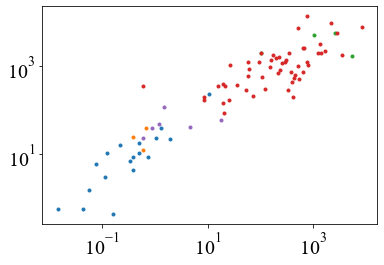

In [9]:
plt.plot(gudel_m_dwarfs['col1']/1.0e14,gudel_m_dwarfs['col2']/1.0e28,'.')
plt.plot(gudel_k_dwarfs['col1']/1.0e14,gudel_k_dwarfs['col2']/1.0e28,'.')
plt.plot(gudel_fk_com['col1']/1.0e14,gudel_fk_com['col2']/1.0e28,'.')

plt.plot(gudel_rs_cvns['col1']/1.0e14,gudel_rs_cvns['col2']/1.0e28,'.')
plt.plot(gudel_by_dra['col1']/1.0e14,gudel_by_dra['col2']/1.0e28,'.')

plt.xscale('log')
plt.yscale('log')

<ipython-input-10-c85ac1ec8c27>:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  thismap.set_bad(color='k')
<ipython-input-10-c85ac1ec8c27>:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  sc.cmap.set_under('k')


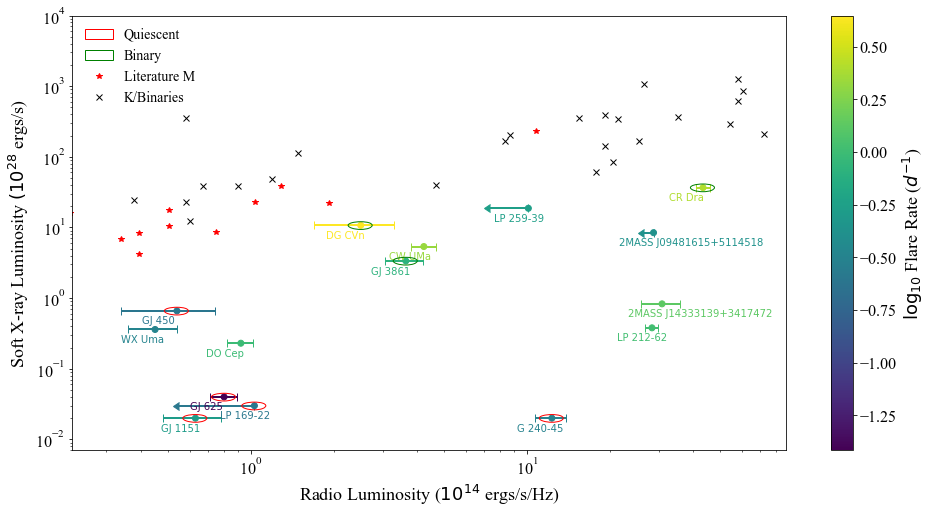

In [10]:
fig = plt.figure(figsize=(16.0,8.0))
ax = plt.gca()

this_mappable = np.log10((flarerate))
bad = ~np.isfinite(this_mappable)
this_mappable[bad] = np.nan

vmin,vmax = np.nanmin(this_mappable),np.nanmax(this_mappable)
this_mappable[bad] = -10

thismap = mpl.cm.viridis
thismap.set_bad(color='k')

sc = plt.scatter(radio,xrayclean,c=this_mappable,cmap=thismap)
sc.cmap.set_under('k')
sc.set_clim(vmin, vmax)

#create colorbar according to the scatter plot
clb = plt.colorbar(sc)
clb.set_label(r'$\log_{10}$ Flare Rate ($d^{-1}$)',fontsize=18)
clb.ax.tick_params(labelsize=16) 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=thismap)
this_mappable[bad] = np.nan
color = np.array([(mapper.to_rgba(v)) for v in this_mappable])

for j in range(15):
    plt.errorbar(radio[j],xrayclean[j],xerr=dradio[j],xuplims=uplims[j],ls='None',c=color[j], lw=2, capsize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(radio)*0.5,np.max(radio)*2)
plt.xlabel('Radio Luminosity ($10^{14}$ ergs/s/Hz)',fontsize=18)
plt.ylabel(r'Soft X-ray Luminosity $(10^{28}$ ergs/s)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


for j, star in enumerate(names):
    wh = np.where(names==star)[0][0]
    plt.text(radio[wh]*0.75,xrayclean[wh]*0.65,star,fontsize=10,c=color[j],fontname='DejaVu Sans')
# fig.colorbar(mpl.cm.ScalarMappable(norm=None,cmap=mpl.cm.hot(flarerate)))

for j, star in enumerate(quiescent):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    f = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='r',zorder=11,
               transform=ax.transData)
    fig.add_artist(f)

    
for j, star in enumerate(binaries):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    g = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='g',zorder=11,
               transform=ax.transData)
    fig.add_artist(g)


mm = plt.plot(gudel_m_dwarfs['col1']/1.0e14,gudel_m_dwarfs['col2']/1.0e28,'*r')
kk = plt.plot(gudel_k_dwarfs['col1']/1.0e14,gudel_k_dwarfs['col2']/1.0e28,'xk')
plt.plot(gudel_fk_com['col1']/1.0e14,gudel_fk_com['col2']/1.0e28,'xk')

plt.plot(gudel_rs_cvns['col1']/1.0e14,gudel_rs_cvns['col2']/1.0e28,'xk')
plt.plot(gudel_by_dra['col1']/1.0e14,gudel_by_dra['col2']/1.0e28,'xk')

# plt.legend([f,g,mm[0],kk[0]],['Quiescent','Binary','Literature M','K/Binaries'],frameon=False,loc=2)
plt.legend([f,g,mm[0],kk[0]],['Quiescent','Binary','Literature M','K/Binaries'],
           framealpha=1,edgecolor='white',loc=2,fontsize=14)

plt.ylim(0.7e-2,1e4)

plt.savefig('gudel_benz_flares_context.png',bbox_inches='tight')
plt.savefig('gudel_benz_flares_context.pdf',bbox_inches='tight')

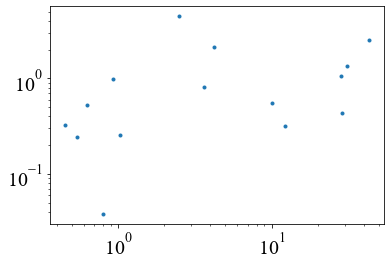

In [11]:
plt.plot(radio,flarerate,'.')
plt.xscale('log')
plt.yscale('log')

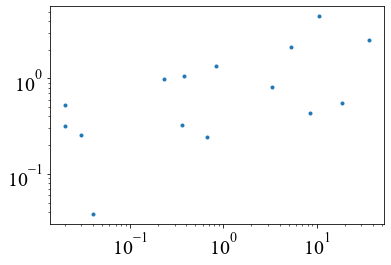

In [12]:
plt.plot(xrayclean,flarerate,'.')
plt.xscale('log')
plt.yscale('log')

In [13]:
tics, time, flux, errs, sects, all_lcs = load_lightcurve(star)

/Users/benjaminpope/code/mtv/notebooks/scripts.py:133: LightkurveDeprecationWarning: The open function is deprecated and may be removed in a future version.
        Use read() instead.
  d = lk.open(fname).remove_nans().normalize()


Loaded from saved files ['../data/lcs/gj_3861_s0015_lc.fits', '../data/lcs/gj_3861_s0016_lc.fits', '../data/lcs/gj_3861_s0023_lc.fits']


/Users/benjaminpope/code/mtv/notebooks/scripts.py:154: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  d = data.PDCSAP_FLUX.remove_nans().normalize()
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


In [14]:
all_lcs = []
all_preds = []
ddir = 'results/reanalysis/'
for star in quiescent:
    print('Doing %s' % star)
    try:
        tics, time, flux, errs, sects, lcs = load_lightcurve(star)
        lcs = lcs[0]
    except:
        tic = data['TIC'][np.where(data['Name']==star)]
        search = lk.search_lightcurvefile('TIC %d' % tic,exptime=120) # why is the TIC wrong?
        print(search)
        lcs = search[0].download().PDCSAP_FLUX.normalize().remove_nans()#.download_all().stitch()
    all_lcs.append(lcs)
    avg_preds = []
    for j in range(len(sects)):
        avg_preds.append(Table.read('%savg_preds_%s_%d.csv' % (ddir,star.replace(' ','_').lower(), j))['avg_preds'].data)
    avg_preds = np.array(avg_preds)
    all_preds.append(avg_preds[0])

Doing GJ 625
Loaded from saved files ['../data/lcs/gj_625_s0016_lc.fits', '../data/lcs/gj_625_s0023_lc.fits', '../data/lcs/gj_625_s0025_lc.fits']


<ipython-input-14-7868f29bdf23>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_preds = np.array(avg_preds)


Doing GJ 450
Loaded from saved files ['../data/lcs/gj_450_s0022_lc.fits']
Doing GJ 1151
Loaded from saved files ['../data/lcs/gj_1151_s0022_lc.fits']
Doing LP 169-22
Loaded from saved files ['../data/lcs/lp_169-22_s0021_lc.fits', '../data/lcs/lp_169-22_s0022_lc.fits']
Doing G 240-45
Loaded from saved files ['../data/lcs/g_240-45_s0014_lc.fits', '../data/lcs/g_240-45_s0015_lc.fits', '../data/lcs/g_240-45_s0016_lc.fits', '../data/lcs/g_240-45_s0017_lc.fits', '../data/lcs/g_240-45_s0018_lc.fits', '../data/lcs/g_240-45_s0019_lc.fits', '../data/lcs/g_240-45_s0021_lc.fits', '../data/lcs/g_240-45_s0022_lc.fits', '../data/lcs/g_240-45_s0024_lc.fits', '../data/lcs/g_240-45_s0025_lc.fits', '../data/lcs/g_240-45_s0026_lc.fits']


<ipython-input-16-f7647bf664b8>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('quiescent_stars_1_sector.png',bbox_inches='tight',rasterized=True)
<ipython-input-16-f7647bf664b8>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('quiescent_stars_1_sector.pdf',bbox_inches='tight',rasterized=True)


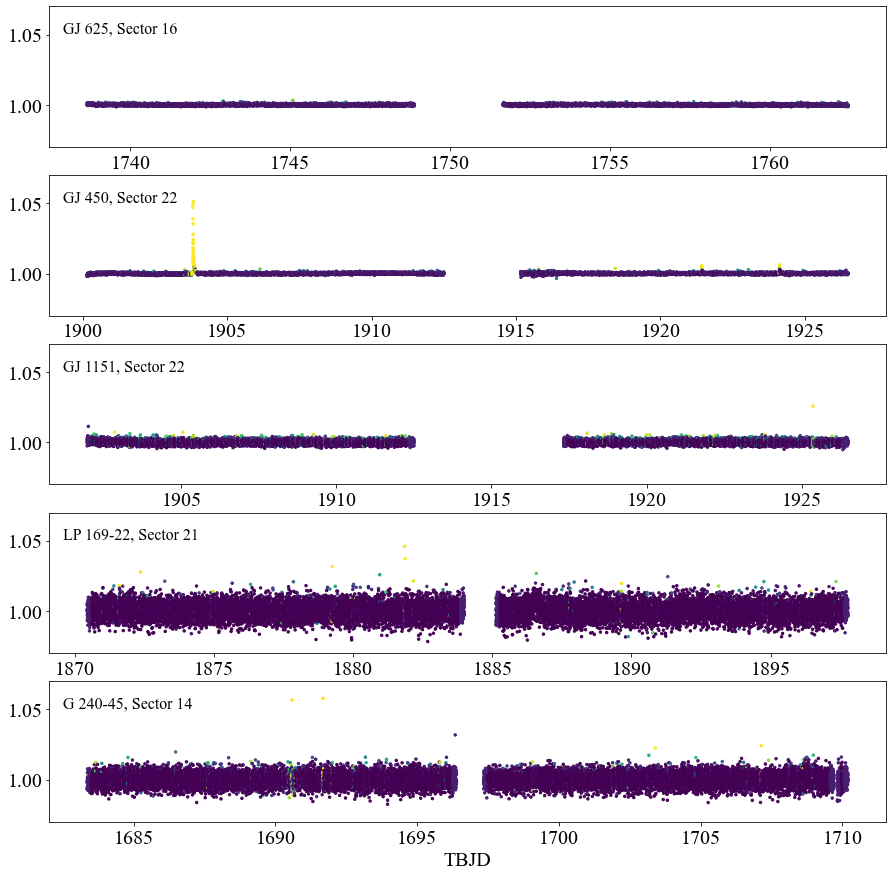

In [16]:
fig, axes = plt.subplots(5,1,figsize=(15,15))
for j, lc in enumerate(all_lcs):
    ax = axes[j]
    ax.set_rasterized(True)
    ax.scatter(lc.time.value,lc.flux,c=all_preds[j],label='%s, Sector %d' % (quiescent[j],lc.sector),vmin=0, vmax=1, s=6)
    leg = ax.legend(frameon=False,loc=2,handlelength=0, handletextpad=0,fontsize=16)
    for item in leg.legendHandles:
        item.set_visible(False)
    ax.set_ylim(0.97,1.07)
    if j == 4:
        ax.set_xlabel('TBJD')
        
plt.savefig('quiescent_stars_1_sector.png',bbox_inches='tight',rasterized=True)
plt.savefig('quiescent_stars_1_sector.pdf',bbox_inches='tight',rasterized=True)

In [17]:
all_lcs = []
all_preds = []

active = [x for x in list(data['Name']) if x not in quiescent]
# active = [x for x in active if x not in ['DO Cep']]

for star in active:
    print('Doing %s' % star)
    try:
        tics, time, flux, errs, sects, lcs = load_lightcurve(star)
        lcs = lcs[0]
    except:
        tic = data['TIC'][np.where(data['Name']==star)]
        search = lk.search_lightcurvefile('TIC %d' % tic,exptime=120) # why is the TIC wrong?
        print(search)
        lcs = search[0].download().PDCSAP_FLUX.normalize().remove_nans()#.download_all().stitch()
    all_lcs.append(lcs)
    avg_preds = []
    for j in range(len(sects)):
        avg_preds.append(Table.read('%savg_preds_%s_%d.csv' % (ddir,star.replace(' ','_').lower(), j))['avg_preds'].data)
    avg_preds = np.array(avg_preds)
    all_preds.append(avg_preds[0])

Doing CW UMa
Loaded from saved files ['../data/lcs/cw_uma_s0022_lc.fits']
Doing LP 259-39
Loaded from saved files ['../data/lcs/lp_259-39_s0021_lc.fits']
Doing WX Uma
Loaded from saved files ['../data/lcs/wx_uma_s0021_lc.fits']
Doing GJ 3861
Loaded from saved files ['../data/lcs/gj_3861_s0015_lc.fits', '../data/lcs/gj_3861_s0016_lc.fits', '../data/lcs/gj_3861_s0023_lc.fits']


<ipython-input-17-5bdc19bd1351>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_preds = np.array(avg_preds)


Doing 2MASS J09481615+5114518
Loaded from saved files ['../data/lcs/2mass_j09481615+5114518_s0021_lc.fits']
Doing LP 212-62
Loaded from saved files ['../data/lcs/lp_212-62_s0021_lc.fits']
Doing DO Cep
Loaded from saved files ['../data/lcs/do_cep_s0016_lc.fits', '../data/lcs/do_cep_s0017_lc.fits', '../data/lcs/do_cep_s0024_lc.fits']
Doing DG CVn
Loaded from saved files ['../data/lcs/dg_cvn_s0023_lc.fits']
Doing CR Dra
Loaded from saved files ['../data/lcs/cr_dra_s0016_lc.fits', '../data/lcs/cr_dra_s0023_lc.fits', '../data/lcs/cr_dra_s0024_lc.fits', '../data/lcs/cr_dra_s0025_lc.fits']
Doing 2MASS J14333139+3417472
Loaded from saved files ['../data/lcs/2mass_j14333139+3417472_s0023_lc.fits']


In [18]:
wx_uma_tpf = lk.search_targetpixelfile('TIC 252803603',exptime=120).download()
corrector = lk.TessPLDCorrector(wx_uma_tpf)
wx_uma_lc = corrector.correct().remove_nans().normalize()

<ipython-input-18-1d8f59737476>:2: LightkurveDeprecationWarning: The TessPLDCorrector class is deprecated and may be removed in a future version.
        Use PLDCorrector instead.
  corrector = lk.TessPLDCorrector(wx_uma_tpf)


<ipython-input-19-ab25c2593cb4>:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('active_stars_1_sector.png',bbox_inches='tight',rasterized=True)
<ipython-input-19-ab25c2593cb4>:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('active_stars_1_sector.pdf',bbox_inches='tight',rasterized=True)


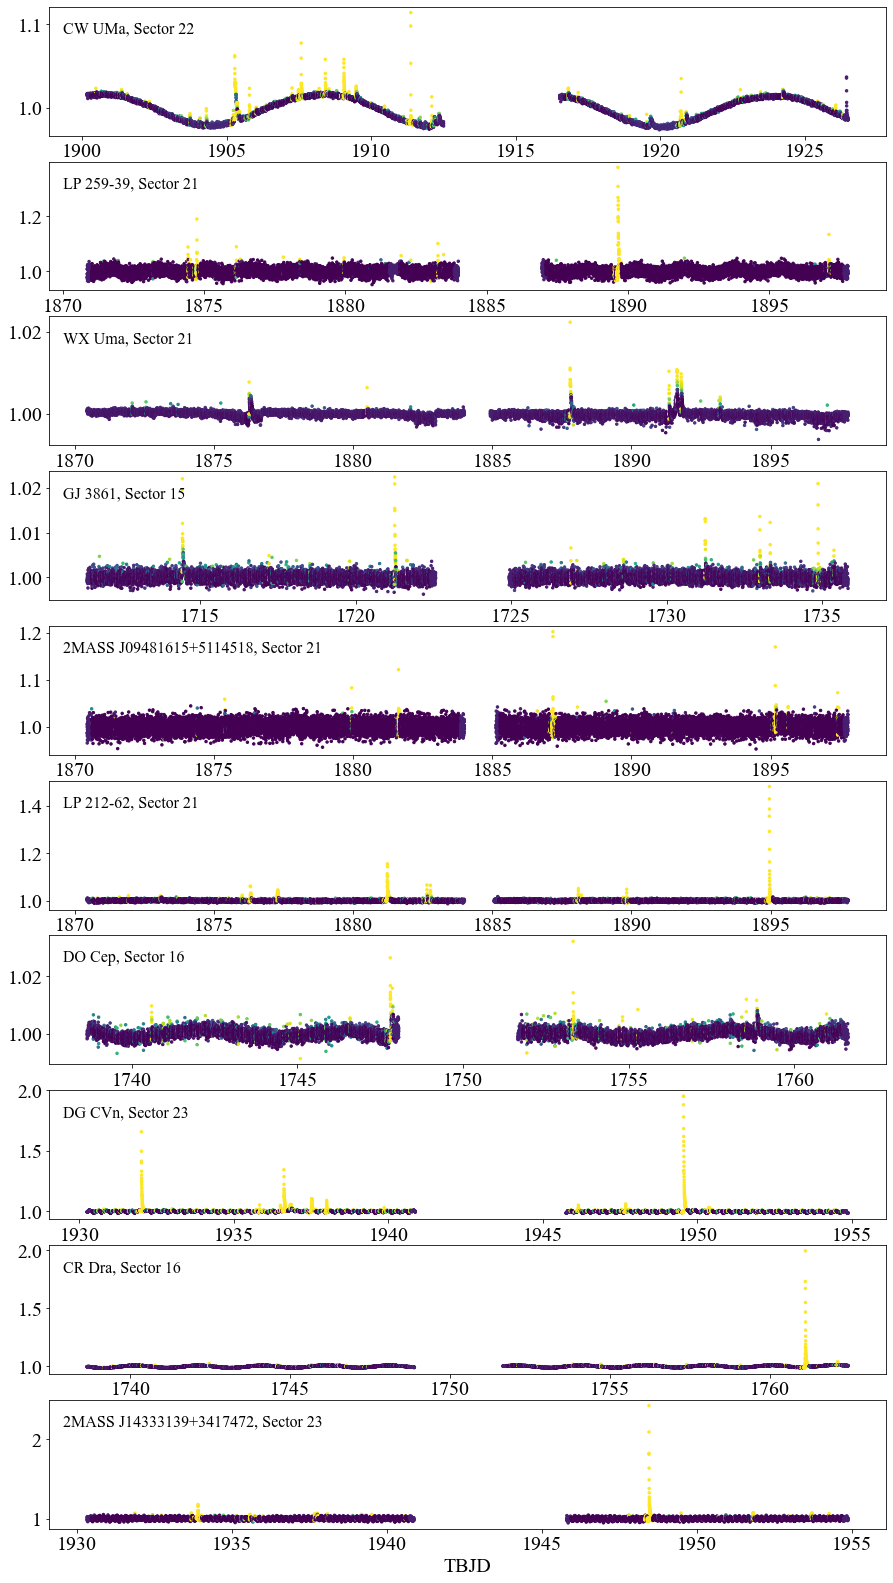

In [19]:
fig, axes = plt.subplots(10,1,figsize=(15,28))
plt.rcParams['font.size'] = 18

for j, lc in enumerate(all_lcs):
#     try:
    lcc = lc.remove_nans()
    ax = axes[j]
    ax.set_rasterized(True)
    ax.scatter(lcc.time.value,lcc.flux,c=all_preds[j],label='%s, Sector %d' % (active[j],lcc.sector),
               vmin=0, vmax=1, s=6)
    leg = ax.legend(frameon=False,loc=2,handlelength=0, handletextpad=0,fontsize=16)
    for item in leg.legendHandles:
        item.set_visible(False)

#         ax.set_ylim(0.93,1.1)
    if j == 9:
        ax.set_xlabel('TBJD')
#     except:
#         lcc = lc.remove_nans()
#         ax = axes[j]
#         ax.set_rasterized(True)
#         ax.plot(lcc.time.value,lcc.flux,'.k',label='%s, Sector %d' % (active[j],lcc.sector),markersize=6)
#         leg = ax.legend(frameon=False,loc=2,fontsize=16)
# #         ax.set_ylim(0.93,1.1)
#         if j == 9:
#             ax.set_xlabel('TBJD')

plt.savefig('active_stars_1_sector.png',bbox_inches='tight',rasterized=True)
plt.savefig('active_stars_1_sector.pdf',bbox_inches='tight',rasterized=True)

## Now let's do the simultaneous ones

In [21]:
stars_simultaneous = {'GJ 450':'2020-03-16T20:11:00',
         '2MASS J09481615+5114518':'2020-01-31T20:45:40'}
simultaneous = stars_simultaneous.keys()

all_lcs = []
all_preds = []

for star in simultaneous:
    print('Doing %s' % star)
    tic = data['TIC'][np.where(data['Name']==star)]
    try:
        tics, time, flux, errs, sects, lcs = load_lightcurve(star)
        lcs = lcs[0]
    except:
        tic = data['TIC'][np.where(data['Name']==star)]
        search = lk.search_lightcurvefile('TIC %d' % tic,exptime=120) # why is the TIC wrong?
        print(search)
        lcs = search[0].download().PDCSAP_FLUX.normalize().remove_nans()#.download_all().stitch()
    all_lcs.append(lcs)
    avg_preds = []
    for j in range(len(sects)):
        avg_preds.append(Table.read('%savg_preds_%s_%d.csv' % (ddir,star.replace(' ','_').lower(), j))['avg_preds'].data)
    avg_preds = np.array(avg_preds)
    all_preds.append(avg_preds[0])

Doing GJ 450
Loaded from saved files ['../data/lcs/gj_450_s0022_lc.fits']
Doing 2MASS J09481615+5114518


/Users/benjaminpope/code/mtv/notebooks/scripts.py:133: LightkurveDeprecationWarning: The open function is deprecated and may be removed in a future version.
        Use read() instead.
  d = lk.open(fname).remove_nans().normalize()
/Users/benjaminpope/code/mtv/notebooks/scripts.py:154: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  d = data.PDCSAP_FLUX.remove_nans().normalize()
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


Loaded from saved files ['../data/lcs/2mass_j09481615+5114518_s0021_lc.fits']


<ipython-input-22-0f7502e0fc78>:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('simultaneous_obs.png',bbox_inches='tight',rasterized=True)
<ipython-input-22-0f7502e0fc78>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('simultaneous_obs.pdf',bbox_inches='tight',rasterized=True)


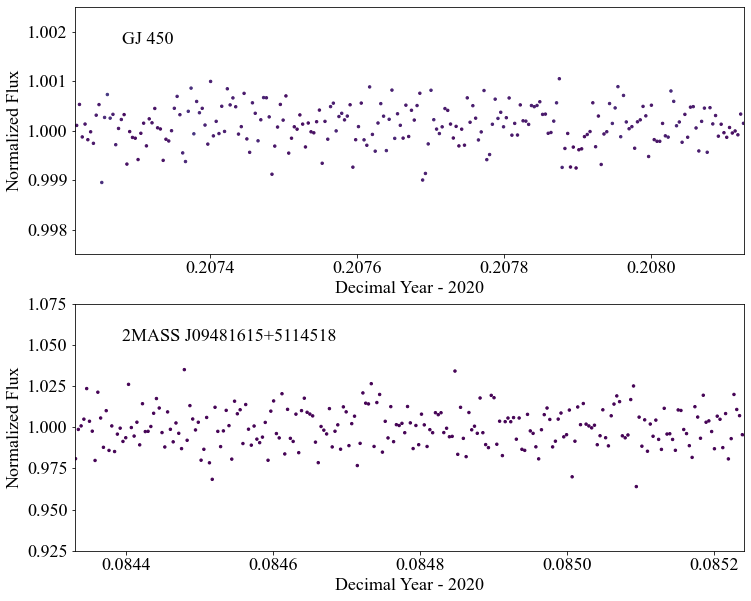

In [22]:
fig, axes = plt.subplots(2,1,figsize=(12.0,10.0))
from astropy.time import Time, TimeDelta

for j, star in enumerate(simultaneous):
    ax = axes[j]
    ax.set_rasterized(True)
    lc = all_lcs[j]
    tstart = stars_simultaneous[star]
    dates = lc.time
    t = Time(tstart, format='isot', scale='utc')
    dt = TimeDelta(3600.*8., format='sec')
    tfinish = t+dt
    
    ax.scatter(dates.decimalyear-2020,lc.flux,c=np.hstack(all_preds[j]),
                        vmin=0, vmax=1, s=6, label=star)
    ax.set_xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
#     ax.axvline(t.decimalyear-2020)
#     ax.axvline(tfinish.decimalyear-2020)

    ax.set_xlabel('Decimal Year - 2020')
    ax.set_ylabel('Normalized Flux')
#     leg = ax.legend(frameon=False,loc=2,handlelength=0, handletextpad=0,fontsize=16)
    ax.annotate(star,xy=(0.07,0.85),xycoords='axes fraction' )
    # plt.ylim(0.98,1.01)
    # plt.xlim(t.decimalyear-2020-0.05,tfinish.decimalyear-2020+0.05)
#     a.colorbar()

axes[0].set_ylim(0.9975,1.0025)
axes[1].set_ylim(0.925,1.075)

plt.savefig('simultaneous_obs.png',bbox_inches='tight',rasterized=True)
plt.savefig('simultaneous_obs.pdf',bbox_inches='tight',rasterized=True)

## Now let's look at the overall flare-rate distribution using the Günther data.

In [48]:
gunther = Table.read('../data/combined_catalog_per_star.csv')
gunther.rename_column('TIC_ID','TIC')

In [49]:
data['TIC']

85334035
166597074
307957392
11893637
252803603
144400022
298164374
453430899
392365135
414587194
207492082


In [50]:
joined = join(gunther,data,keys='TIC')
joined.sort('Name')
print(joined['Name','TIC'])

          Name             TIC   
----------------------- ---------
2MASS J09481615+5114518 453430899
                 CR Dra 207436278
                 CW UMa  85334035
                 DO Cep 414587194
               G 240-45 307957392
                GJ 1151  11893637
                GJ 3861 298164374
                 GJ 450 144400022
                 GJ 625 207492082
              LP 169-22 148673115
              LP 212-62 392365135
              LP 259-39 166597074
                 WX Uma 252803603


In [51]:
data.sort('Name')
print(data)

          Name          LOFAR Lum (x1E14 ergs/s/Hz) ... N Sectors    TIC   
----------------------- --------------------------- ... --------- ---------
2MASS J09481615+5114518                       28.71 ...         1 453430899
2MASS J14333139+3417472                       30.82 ...         1 409372963
                 CR Dra                       43.38 ...         4 207436278
                 CW UMa                        4.23 ...         1  85334035
                 DG CVn                         2.5 ...         1 368129164
                 DO Cep                        0.92 ...         3 414587194
               G 240-45                        12.3 ...        11 307957392
                GJ 1151                        0.63 ...         1  11893637
                GJ 3861                        3.64 ...         3 298164374
                 GJ 450                        0.54 ...         1 144400022
                 GJ 625                         0.8 ...         3 207492082
            

In [52]:
# 2MASS J14333139+3417472 and DG CVn missing from Gunther?

In [53]:
gunther.sort('TIC')

In [56]:
# rm /Users/benjaminpope/.astropy/cache/astroquery/Simbad/*


In [57]:
data.keys()

['Name',
 'LOFAR Lum (x1E14 ergs/s/Hz)',
 'Soft X-ray Lum (x1E28 ergs/s)',
 'Uncert. Lofar Lum',
 'Literature Rotation Period',
 'Rotation Period',
 'Flare Rate',
 'N Flares',
 'N Sectors',
 'TIC']

In [58]:
print(joined.keys())

['TIC', 'OBS_Sector', 'TICv8_ra', 'TICv8_dec', 'TICv8_Teff', 'TICv8_Tmag', 'TICv8_d', 'BANYAN_BEST_HYP', 'N_flares', 'N_flares_per_day', 'flare_amp_max', 'flare_amp_median', 'flare_dur_max', 'flare_dur_median', 'flare_prob_max', 'flare_prob_median', 'Name', 'LOFAR Lum (x1E14 ergs/s/Hz)', 'Soft X-ray Lum (x1E28 ergs/s)', 'Uncert. Lofar Lum', 'Literature Rotation Period', 'Rotation Period', 'Flare Rate', 'N Flares', 'N Sectors']


In [60]:
joined['Name','N_flares','N Flares']

Name,N_flares,N Flares
str23,int64,int64
2MASS J09481615+5114518,9,12
CR Dra,253,243
CW UMa,51,52
DO Cep,44,72
G 240-45,31,93
GJ 1151,3,13
GJ 3861,46,54
GJ 450,5,6
GJ 625,2,3


## Now let's look at Tara Murphy's stars

In [33]:
from scripts import load_lightcurve

In [34]:
load_lightcurve('TIC 409372963',from_saved=False)

/Users/benjaminpope/code/mtv/notebooks/scripts.py:117: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search = lk.search_lightcurvefile(starname,radius=radius,exptime=120)


Downloaded lightcurve!


/Users/benjaminpope/code/mtv/notebooks/scripts.py:154: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  d = data.PDCSAP_FLUX.remove_nans().normalize()


([409372963],
 [array([1930.33257113, 1930.33396005, 1930.33534897, ..., 1954.87448167,
         1954.87725943, 1954.87864831])],
 [<Quantity [1.0125475 , 1.0134066 , 0.9824146 , ..., 0.9778093 , 1.0039206 ,
             0.99903804]>],
 [<Quantity [0.01518392, 0.01519981, 0.01512171, ..., 0.01290987, 0.0129533 ,
             0.01297044]>],
 [23],
 LightCurveCollection of 1 objects:
     0: <TessLightCurve LABEL="TIC 409372963" SECTOR=23 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>)

In [35]:
tics, time, flux, errs, sects, data_all = load_lightcurve('TIC 409372963',from_saved=False)

/Users/benjaminpope/code/mtv/notebooks/scripts.py:117: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search = lk.search_lightcurvefile(starname,radius=radius,exptime=120)
/Users/benjaminpope/code/mtv/notebooks/scripts.py:154: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  d = data.PDCSAP_FLUX.remove_nans().normalize()


Downloaded lightcurve!


In [36]:
lk.search_lightcurve('TIC 409372963',exptime=120).download().filename

'/Users/benjaminpope/.lightkurve-cache/mastDownload/TESS/tess2020078014623-s0023-0000000409372963-0177-s/tess2020078014623-s0023-0000000409372963-0177-s_lc.fits'

In [37]:
from astroquery.simbad import Simbad
Simbad.reset_votable_fields()
Simbad.add_votable_fields('sptype','id(tic)')

In [38]:
# Simbad.list_votable_fields()

In [39]:
murphy = Table.read('../data/murphystars.csv')

mtics, mtypes = [],[]
for name in tqdm(murphy['Name']):
    query = Simbad.query_object(name)
    try:
        mtics.append(query['ID_tic'][0].strip('TIC '))
        mtypes.append(query['SP_TYPE'][0])
    except:
        mtics.append(None)
        mtypes.append(None)
mtics = Column(np.array(mtics),name='TIC')
mtics[-1] = '375621179' # bet Aql B
mtypes = Column(np.array(mtypes),name='sptype')
murphy.add_columns([mtics,mtypes])

murphy_mdwarfs = [('M' in str(t)) for t in mtypes]
pritchard_mdwarfs = ['Pri' in str(t) for t in murphy['Provenance']] # filter for pritchard
murphy = murphy[np.logical_and(pritchard_mdwarfs,murphy_mdwarfs)]
murphy['TIC']= murphy['TIC'].astype('int')

joined_murphy = join(gunther,murphy,keys='TIC')


<ipython-input-39-57ef43d18b1a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for name in tqdm(murphy['Name']):


/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : * kap02 Pup
  warnings.warn("Warning: The script line number %i raised "
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'WOH-S2' this identifier has an incorrect format for catalog: 	WOH : Westerlund + Olander + Hedin
  warnings.warn("Warning: The script line number %i raised "
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : 2MASS J11402076-3305190
  warnings.warn("Warning

In [40]:
list(joined_murphy['N_flares_per_day'])

[1.2727272727272727,
 1.7454545454545454,
 0.32727272727272727,
 1.5735537190082645,
 3.8545454545454545,
 0.6181818181818182,
 3.4909090909090907,
 1.490909090909091,
 1.0,
 2.2181818181818183,
 1.0545454545454545]

In [41]:
set(murphy['Name']).difference(set(joined_murphy['Name']))

{'G 131-26',
 'G 165-61',
 'G 183-10',
 'G124-44',
 'Ross 614',
 'UCAC3 152-281176',
 '[W60] D43',
 'bet Aql B'}

So all of the Pritchard targets flare at high rates - mostly more than once a day - no planetary candidates in this! 